# Store Sales - Time Series Forecasting
---

Using machine learning to predict grocery sales

In this notebook we will be solving the problem from the competiton: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) from [Kaggle](https://www.kaggle.com/)

### Summary:
*   In this competition, you’ll use time-series forecasting to forecast store sales on data from **Corporación Favorita**, a large Ecuadorian-based grocery retailer.
    *   Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.  
    You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

* The evaluation metric for this competition is Root Mean Squared Logarithmic Error - RMSLE.

### File Descriptions and Data Field Information

#### `train.csv`
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

*   **store_nbr** identifies the store at which the products are sold.
*   **family** identifies the type of product sold.
*   **sales** gives the total sales for a product family at a particular store at a given date.  
    Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

#### `test.csv`
The test data, having the same features as the training data.  
You will predict the target sales for the dates in this file.  
*   The dates in the test data are for the 15 days after the last date in the training data.

#### `sample_submission.csv`
*   A sample submission file in the correct format.

#### `stores.csv`
Store metadata, including city, state, type, and cluster.
*   **cluster** is a grouping of similar stores.

#### `oil.csv`
Daily oil price.  
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### `holidays_events.csv`
Holidays and Events, with metadata  


### NOTES:
Pay special attention to the transferred column.  
*   A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government.

*   A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is **Transfer**.  
    *   For example, the holiday ***Independencia de Guayaquil*** was transferred from **2012-10-09** to **2012-10-12**, which means it was celebrated on **2012-10-12**.  

*   Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend).  

*   These are frequently made up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the **Bridge**.

*   Additional holidays are days added a regular calendar holiday, for example, as typically happens around **Christmas** (making Christmas Eve a holiday).

*   Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. **Supermarket sales could be affected by this.**

*   A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

Extracting file from the `.zip`

In [2]:
import zipfile
from pathlib import Path

Path("data").mkdir(parents=True, exist_ok=True)

file_path = Path("data/train.csv")
if not file_path.is_file():
    with zipfile.ZipFile("./store-sales-time-series-forecasting.zip", 'r') as zf:
        zf.extractall("./data/")

Reading the `train.csv` file:

In [4]:
import pandas as pd
import numpy as np
train_path = "./data/train.csv"

df = pd.read_csv(
    train_path,
    parse_dates=['date']
    )

df = df.set_index('date').to_period('D')
df = df.set_index(['store_nbr', 'family'], append=True)
average_sales = df.groupby('date').mean()['sales']

Let's check how the dataset is composed:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [7]:
stores = pd.read_csv("./data/stores.csv")

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Defining some parameters for the plots:

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Plotting a graph for the average sales:

In [6]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Freq: D, Name: sales, dtype: float64

Text(0.5, 1.0, 'Average Sales (2013 - 2017)')

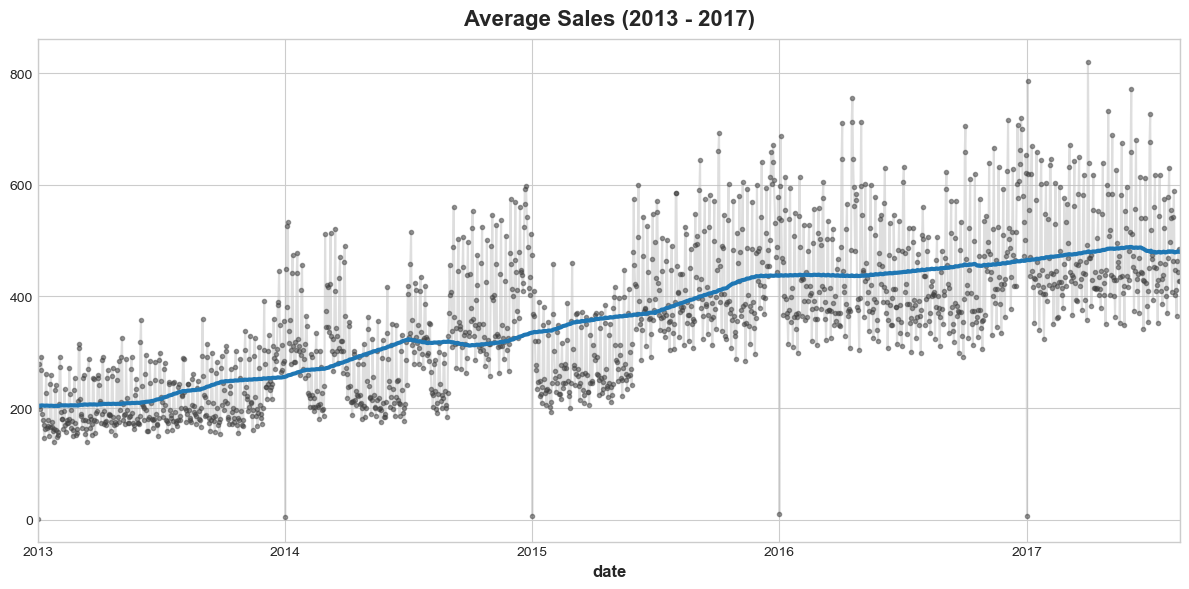

In [16]:
import matplotlib.pyplot as plt

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

plt.figure(figsize=(12, 6))
ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.set_title("Average Sales (2013 - 2017)")